# General Pipeline

## Imports

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp
import IPython
from IPython.display import Audio, HTML
from scipy.io import wavfile
import math
import cv2
import subprocess
import scipy
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams["figure.figsize"] = (14,4)
import librosa
from moviepy.editor import VideoFileClip, AudioFileClip, CompositeAudioClip
from matplotlib import cm
import moviepy

## Data loading
Here is where songs + images can be loaded

The goal function are get_info and get_gif, which can be changed for more interesting parameter searching and mappings. 

In [32]:
data_fpath = p_join(abspath(''), 'data')

### Song loading

#### Choose song

In [7]:
song_name = "Patti Austin - Thats Enough For Me"
# Or
# song_name = "brand1"
# song_name = "snd"
# song_name = "stravinsky"
# song_name = "harry_styles"

In [8]:

# Audio load
audio_name = p_join(data_fpath, song_name +".wav")
audio, sr = librosa.load(audio_name, sr=None)
if len(audio.shape) > 1: # If stereo, use only the left channel
    audio = audio.T[0]
audio = audio[0:10*sr] # Keep max 10s of the audio
Audio(audio, rate=sr)

NameError: name 'p_join' is not defined

#### Song details

In [26]:
print(len(audio)/ sr, len(audio), sr)

10.0 441000 44100


### Image loading

In [30]:
img_title = 'apple'

640x960


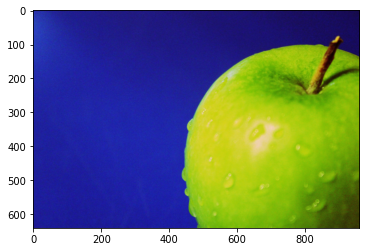

In [34]:
# take a look at the image

img_path = p_join(data_fpath, img_title + '.jpg')
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def resize_image(img, target_width=480):
    height, width, layers = img.shape
    scale = target_width / width
    target_width = int(width * scale)
    target_height = int(height * scale)
    dim = (target_width, target_height)
    return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
img = resize_image(img, target_width=960)

plt.imshow(img)
print("{}x{}".format(*img.shape))

## Data processing

### Function 

In [8]:
def normalize_frames(frames, norm_functions):
    return [
        { key: (norm_functions[key](value)
                if key in norm_functions else value)
         for key, value in frame.items() }
        for frame in frames
    ]

# function that takes audio as input and return different features
def get_info(audio_name, window_size):
    # audio_name -- name of audiofile
    # window_size -- we split audio into frames, this is the length of the frame in seconds
    x, sr = librosa.load(audio_name, sr = None)
    seconds = len(x) / sr
    frame_len = int(len(x) / (seconds / window_size))
    frames = []
    for ind in range(0, len(x) + 1, frame_len):
        current_amplitude = x[ind:ind + frame_len]
        fft = librosa.stft(current_amplitude, n_fft=len(current_amplitude), hop_length=len(current_amplitude))
        freqs = fft[:, 0]
        freqs = librosa.amplitude_to_db(abs(freqs))
        _, phase = librosa.magphase(fft)
        phase = phase[:, 0]
        frames.append({
            'amplitude':current_amplitude,
            'amplitude_abs_mean': np.mean(np.abs(current_amplitude)),
            'frequency':freqs,
            'phase':phase,
        })
        #timbre = 0
    print(len(frames))
    print(librosa.stft(x, n_fft=frame_len, hop_length = frame_len // 4))
    max_amplitude_mean = max(frame['amplitude_abs_mean'] for frame in frames)
    return normalize_frames(frames, {
        'amplitude_abs_mean': lambda x: x / max_amplitude_mean
    })

def get_features(audio, sr, window_size_s):
    x = audio
    features = {}
    frame_len = int(sr * window_size_s)
    hop_length = frame_len // 4
    # number of samples
    n_frames = int(math.ceil(len(x) / hop_length))
    
    # stft
    stft = librosa.stft(x, n_fft=frame_len, hop_length = hop_length)
    print(stft.shape, librosa.fft_frequencies(sr=sr, n_fft=frame_len).shape)
    features['stft'] = stft.T
    features['stft_db'] = librosa.amplitude_to_db(np.abs(stft)).T
    _, phase = librosa.magphase(stft)
    features['stft_phase'] = phase.T
    
    features['amplitude_abs_mean'] = []
    features['values'] = []
    
    for i in range(n_frames):
        window = x[max(0, i*hop_length - frame_len//2) : i*hop_length + frame_len//2]
        features['values'].append(window)
        features['amplitude_abs_mean'].append(np.mean(np.abs(window)))
        
    features['amplitude_abs_mean'] /= np.max(np.abs(features['amplitude_abs_mean']))

    
    # convert dict of lists to list of dicts
    return [dict(zip(features,t), 
                param_n_fft=frame_len
                ) for t in zip(*features.values())]

(2206, 401) (2206,)
401 2205


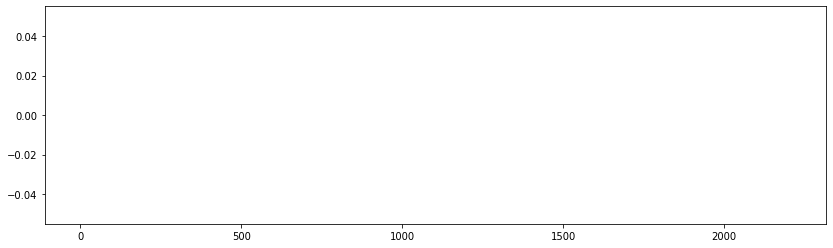

<BarContainer object of 2206 artists>

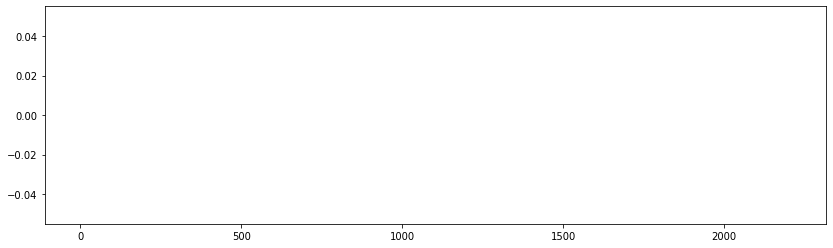

In [35]:
frames = get_features(audio, sr, 0.1)
frame = frames[0]
print(len(frames), len(np.abs(frame["values"])))
plt.bar(np.arange(len(frame["stft"])), np.abs(frames[0]["stft"]))
plt.show()
frame = frames[1]
plt.bar(np.arange(len(frame["stft"])), np.abs(frames[1]["stft"]))

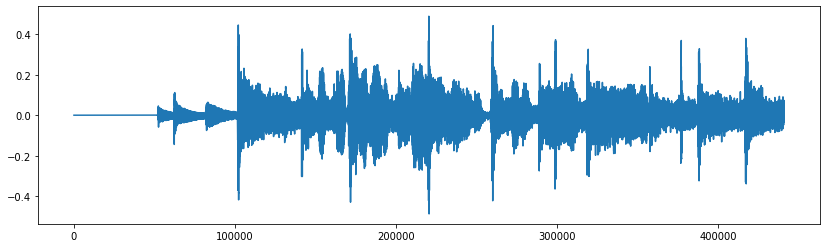

In [10]:
plt.plot(audio)

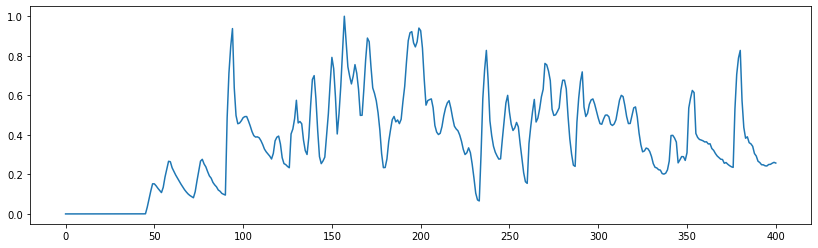

In [36]:
plt.plot([frame['amplitude_abs_mean'] for frame in frames])
#plt.ylim((0,1))
plt.show()

### RGB matching

In [12]:
def get_bins(stft_sample_first, num_bins):
    bin_size = int(len(stft_sample_first)/num_bins)
    # bin the frequencies into three channels (low, middle, high frequencies) and compute average amplitude for each bin
    binned_freq = np.array([np.mean(stft_sample_first[i*bin_size : (i+1)*bin_size]) for i in range(num_bins)])
    return binned_freq

def get_bounds(initial_rgb, initial_ampl, max_ampl, color_range):
    lower = initial_rgb - ((initial_ampl/max_ampl) * color_range)
    upper = initial_rgb + ( (1-(initial_ampl/max_ampl)) * color_range)
    return lower, upper

def get_new_rgb_from_range(lower, upper, max_ampl, ampl):
    return (ampl/max_ampl) * (upper-lower) + lower

def sound_to_image(img, features, features_initial, sr, mode="maximum", window_size=100):
    """
    mode:
    maximum = map the whole amplitude range to the whole color range
    window = map the whole amplitude range to a color range of size window_size
    """
    mean_rgb = np.array([np.mean(img[:,:,i]) for i in range(3)])
    r = [mean_rgb[0]]
    g = [mean_rgb[1]]
    b = [mean_rgb[2]]

    # first sample bin frequencies and compute mean amplitude for each frequency
    stft_sample_first = np.abs(features_initial["stft"])
    num_bins = 3
    binned_freq_init = get_bins(stft_sample_first, num_bins)
    
    # find maximum amplitude of first sample to get upper bound for the mapping
    max_ampl = (255 * binned_freq_init) / mean_rgb
    # window
    if mode=="window":
        lower, upper = get_bounds(mean_rgb, binned_freq_init, max_ampl, window_size)
    else:
        lower = 0
        upper = 0

    # modify image according to incoming new sample
    stft_sample = np.abs(features["stft"])

    binned_freq_curr = get_bins(stft_sample, num_bins)
    # modify image accordingly
    # compute RGB values of previous image
    # prev_values = np.array([np.mean(im_prev[:,:,i]) for i in range(3)])
    # change according to change in frequency 
    # ratio of frequencies = ratio of colors
    if mode == "maximum":
        # ration of frequency to max frequency = ratio of color to max color
        new_values = (255 * binned_freq_curr) / max_ampl
    # get new values in given range (not from 0 to 255 but lower to upper which is a span of "color_range")
    else:
        new_values = get_new_rgb_from_range(lower, upper, max_ampl, binned_freq_curr)
    #new_values = ((prev_values) * binned_freq_curr)/(binned_freq_prev) # (255 * binned_freq_curr) / max_ampl #(prev_values * binned_freq_curr)/binned_freq_prev
    #print(new_values)
    
    im_new = img.copy()
    im_new = change_rgb(im_new, new_values)
    
    return im_new

### Histogram matching

In [13]:
from skimage.exposure import match_histograms

def envelope_to_histogram(sample, scale, plot=False):
    """
    takes sound sample and scale which defines the sum of all bins in the histogram.
    In an image this would be heigt*width = number of pixels
    scale has to be <= the number of pixels in the image channel
    
    returns histogram normalized that would correspond to an image with "scale" pixels
    """
    num_bins = 256 # one bin for each brightness level in an image
    bin_size = int(len(sample)/num_bins) # the amount of time steps that are summarized in one bin
    if plot:
        print(num_bins, "with size", bin_size)
    binned_envelope = np.array([np.mean(sample[i:i+bin_size]) for i in range(num_bins)])
    
    # if a sample has no sound we add a small value to each bin
    if binned_envelope.sum() < 0.1:
        binned_envelope += 1
    # normalize bins to sum=scale
    normalized_float = (binned_envelope/binned_envelope.sum()) * scale
    normalized = normalized_float.astype(int)
    # make sure that the sum is correct after conversion to integer
    while normalized.sum() != scale:
        normalized_float = normalized_float % 1 # get only digits after comma
        idx_biggest_number = np.argmax(normalized_float)
        normalized[np.argmax(normalized_float)] += 1
        normalized_float[idx_biggest_number] = 0
    return normalized

def get_reference_image(im_channel, diff_sound_hist):
    """
    @param im_channel the image channel we want to change
    @param diff_sound_hist the difference between two sound histograms according to which we want to modify the channel
    get difference of two sound histograms add to initial channel and compute reference image for the channel
    the reference image is an image with the desired histogram but not the image content 
    it can be used for histogram mapping with scipys match_histograms function
    """
    h,w = im_channel.shape
    
    # histogram of initial color channel
    idx, counts = np.unique(im_channel, return_counts = True)
    hist_im = np.zeros(256, dtype=int)
    hist_im[idx] = counts
    
    # add difference to image histogram
    y_ax = hist_im + diff_sound_hist
    
    # perform all this normalization to have the correct pixel amount
    y_ax[y_ax<0]=0 # make positive
    y_ax_float = (y_ax/y_ax.sum())*w*h # normalize again to w*h to have the correct pixel amount
    y_ax = y_ax_float.astype(int)
    while y_ax.sum() != w*h:
        y_ax_float = y_ax_float % 1 # get only digits after comma
        idx_biggest_number = np.argmax(y_ax_float)
        y_ax[idx_biggest_number] += 1
        y_ax_float[idx_biggest_number] = 0
    
    # check that pixel amount is correct
    assert(h*w==y_ax.sum())
    
    # build an image with the desired pixel histogram, the position of each pixel does not matter
    im_ref = np.zeros((h,w), dtype=np.uint8)
    intensity_bar = 0 # [0,255] which bar we are in right now
    count = 0 # keep track of height of bar
    for i in range(h):
        for j in range(w):
            while count == y_ax[intensity_bar]:
                intensity_bar += 1
                count = 0
            im_ref[i,j] = intensity_bar
            count += 1
            
    return im_ref

def get_sub_samples(sample, num=3):
    """
    function that devides a sound sample into three equal sized sound samples (one for each color channel)
    """
    subsample_len = int(len(sample)/num)
    return sample[:subsample_len], sample[subsample_len:subsample_len*2], sample[subsample_len*2:subsample_len*3]

def image_from_histograms(sample1, sample2, im, scale):
    """
    """
    
    # cut into three subsamples and transform envelopes to histograms
    r1, g1, b1 = (envelope_to_histogram(subsample, scale) for subsample in get_sub_samples(sample1))
    r2, g2, b2 = (envelope_to_histogram(subsample, scale) for subsample in get_sub_samples(sample2))
    
    # reference image in which we store the manipulated color channels
    ref_im = np.zeros(im.shape)
    
    # calculate the differences between the three channels
    diff_red = r2-r1
    diff_blue = b2-b1
    diff_green = g2-g1
    #print(f"sum should be scale ={scale}: {r1.sum()==scale}, {r2.sum()==scale}, {b1.sum()==scale}, {b2.sum()==scale}, {g1.sum()==scale}, {g2.sum()==scale}")
    #print(len(diff_red))
    
    # get reference image for each channel
    ref_im[:,:,0] = get_reference_image(im[:,:,0], diff_red)
    ref_im[:,:,1] = get_reference_image(im[:,:,1], diff_green)
    ref_im[:,:,2] = get_reference_image(im[:,:,2], diff_blue)
    
    # do the actual matching
    new_im = match_histograms(im, ref_im, multichannel=True)
    return new_im

def match_histograms_from_envelope(features1, features2, img):
    # keep the same scale as before
    h,w,d = img.shape # image height and with to know the sum of the bins of the image histogram
    scale = int(h*w)

    sample1 = features1["values"] #audio_pos[sample_len*(i-1):i*sample_len]
    sample1[sample1<0] = 0
    # use only positive part
    sample2 = features2["values"]
    sample2[sample2<0] = 0
    
    if len(sample1) <= 256*3:
        print("reference sample is too short")
        return img
    if len(sample2) <= 256*3:
        print("new sample is too short")
        return img
    
    new_im = image_from_histograms(sample1, sample2, img, scale)
    return new_im

In [14]:
# helper function that should be different for other approaches of mapping
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    new_img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return new_img

def decrease_brightness(img, value=-30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = -value
    v[v < lim] = 0
    v[v >= lim] -= (-value)

    final_hsv = cv2.merge((h, s, v))
    new_img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return new_img

def change_brightness(img, value=0):
    if value == 0:
        return img
    if value < 0:
        return decrease_brightness(img, value)
    return increase_brightness(img, value)

def change_brightness2(img, brightness_offset):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = np.clip(v + brightness_offset, 0, 255).astype('uint8')
    return cv2.cvtColor(cv2.merge((h, s, v)), cv2.COLOR_HSV2BGR)

def change_rgb(img, target_values):
    """changes rgb values in place to target_values"""
    # current BGR values of image
    RGB = np.mean(np.mean(img, axis = 1), axis=0)
    difference = target_values - RGB
    for i in range(3):
        # do not change if target value is 0 bc that means that the feature is not relevant
        if target_values[i] == 0:
            continue
        # difference image for cv2.subtract/add
        diff = np.zeros_like(img)
        # fill with the magnitude of the difference between the means
        diff[:,:,i] = abs(difference[i])
        # if difference is negative we need to decrease the mean of the channel i
        if difference[i] < 0:
            img = cv2.subtract(img, diff)
        # if positive we need to increase it
        else:
            img = cv2.add(img, diff)
    # write the resulting image back to the file
    return img

## Drawing shapes

Input: frequency, amplitude, time + hyperparameters

Parameters:
- angle within spiral: frequency, time
- distance from centre: time, freqency
- oscillation magnitude: frequency
- oscillation frequency: frequency
- alpha: amplitude, frequency
- radius: amplitude, frequency
- color: frequency

In [15]:
def draw_shapes(img, features, t, sr):
    img = img.copy()
    h, w, _ = img.shape
    db_threshold = 8
    center_x, center_y = w//2, h//2
    
    frequencies = librosa.fft_frequencies(sr=sr, n_fft=features['param_n_fft'])
    freq_min, freq_max = 30, 15000 # minimum and maximum frequencies to draw
    freq_indices = (frequencies >= freq_min) & (frequencies <= freq_max) # indices of frequencies to draw
    frequencies = frequencies[freq_indices]
    
    for i, val in enumerate(features['stft_db'][freq_indices]):
        shapes = np.zeros_like(img, np.uint8)
        mask = np.zeros_like(img, np.uint8)
    
        magnitude = val - db_threshold
        if magnitude <= 0:
            continue
        freq = frequencies[i]
        rel_frequency = (np.log(freq) - np.log(freq_min)) / (np.log(freq_max) - np.log(freq_min)) # a number between 0 (=lowest frequency) and 1 (=highest frequency)
        def spiral(x):
            x = np.interp(x, [0, 0.2, 1.], [0., 0.1, 1.])
            magnitude = x ** 0.5 * 0.6
            magnitude_offset = 0.1 * np.interp(x, [0, 1], [0.2, 1]) * np.sin((2*np.pi*t + 1000) * np.interp(x, [0,1], [0.5, 4]))
            magnitude += magnitude_offset
            angle = 2*np.pi* (2*x - t*0.6)
            point = (
                center_x + int( magnitude * np.cos(angle) * min(w,h) ),
                center_y + int( magnitude * np.sin(angle) * min(w,h) )
            )
            return point
        intensity = np.log(magnitude+1) * np.interp(rel_frequency, [0,1], [1., 0.2])
        center = spiral(rel_frequency)
        radius = int(intensity * min(h, w) * 0.03)
        rgb = np.array(cm.hsv(1 - rel_frequency))*255
        alpha = np.clip(
            intensity * 0.35,
            0, 1)
        
        #cv2.circle(img, center, radius, rgba, cv2.FILLED)
        cv2.circle(shapes, center, radius, rgb, cv2.FILLED)
        cv2.circle(mask, center, radius, (255,255,255), cv2.FILLED)
    
        # Generate output by blending image with shapes image, using the mask
        mask = mask.astype(bool)
        img[mask] = cv2.addWeighted(img, alpha, shapes, alpha, 0)[mask]
    return img

In [16]:
def get_image_frame(source_img, features, t, sr, features_initial=0):
    img = source_img

    #img = match_histograms_from_envelope(features_initial, features, img)
    #img = sound_to_image(img, features, features_initial, sr, mode="maximum")
    img = change_brightness2(img, (features['amplitude_abs_mean'] - 0.5) * 1 * 255)
    img = draw_shapes(img, features, t, sr)
    
    return img

def get_image_sequence(source_img, frames, sr):
    return [get_image_frame(source_img, frame, i/(len(frames)-1), sr, frames[len(frames)//2]) for i, frame in enumerate(frames)]

print("Generating {} images".format(len(frames)))
imgs = get_image_sequence(img, frames, sr)
print("Done")

Generating 401 images
Done


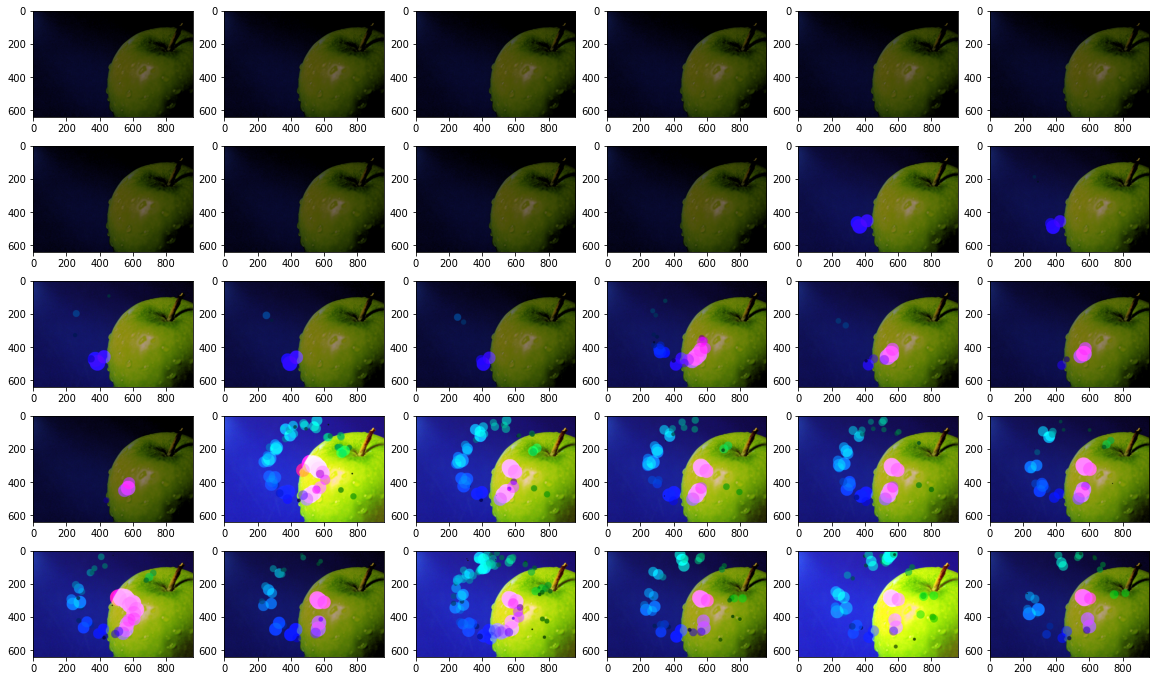

In [17]:
fig = plt.figure(figsize=(20, 12))
for i in range(min(30,len(imgs))):
    fig.add_subplot(5,6,i+1)
    plt.imshow(imgs[i*5])
plt.show()

In [18]:
def generate_video(imgs, fps, video_name, target_width=480):
    height, width, layers = imgs[0].shape
    video = cv2.VideoWriter(video_name, 0, fps, (width, height))
    for image in imgs:
        video.write(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    cv2.destroyAllWindows()
    video.release()

def merge_video_audio(video_name, fps, audio_name, video_out_name):
    # load the video
    video_clip = VideoFileClip(video_name)
    # load the audio
    audio_clip = AudioFileClip(audio_name)
    common_end = min(video_clip.end, audio_clip.end) # ends should be the same, just to be sure
    video_clip = video_clip.subclip(0, common_end)
    audio_clip = audio_clip.subclip(0, common_end)
    final_clip = video_clip.set_audio(audio_clip)
    final_clip.write_videofile(video_out_name, fps=fps)


video_name = 'output_temp.avi' # intermediate file without audio
video_out_name = "output.mp4"
duration_s = len(audio) / sr
fps = len(imgs) / duration_s
generate_video(imgs, fps, video_name)

merge_video_audio(video_name, fps, audio_name, video_out_name)

Moviepy - Building video output.mp4.
MoviePy - Writing audio in outputTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video output.mp4



Moviepy - Done !
Moviepy - video ready output.mp4


In [19]:
HTML("""<video width="400" controls><source src="{}"></video>""".format(video_out_name))

In [20]:
for file in ["demo1_freqbins", "demo2_brightness_spiral", "demo3_full"]:
    display(HTML("""<video width="400" controls><source src="demos/{}.mp4"></video>""".format(file)))

### Entropy/Onset differences

In [37]:
def compute_rhythm(song):
    """
    Outputs a list of timestamps, in seconds, for which 
    onsets were detected by using the default onset 
    detection function. 
    """
    # Onsets
    onsets_string = subprocess.check_output(['aubioonset', '-i', song])
    onsets = onsets_string.decode("utf-8").strip().split('\n')
    onsets = [float(onset) for onset in onsets]
    # Diffs
    # Gives us a list of timings between onsets
    diffs = np.abs(np.diff(onsets)) # Calculate the n-th discrete difference along the given axis
    grid = np.linspace(0, 10, 1000)
    density = scipy.stats.gaussian_kde(diffs)
    hist = density(grid)
    # Entropy
    entropy = scipy.stats.entropy(hist) # Shannon's entropy 

    return {
    'entropy': entropy,
    'recording': song,
    'onsets': onsets,
    'diffs': diffs,
    'hist': hist,
    'grid': grid
    }

In [44]:
def generateOnsetDiffs(values):
    print('od')

    onsets = values['onsets']
    diffs = values['diffs']

    plt.title('Onset Diffs')
    plt.ylabel('Onset Time Difference (s)')
    plt.xlabel('Time (s)')
    graphDiffs = np.append(diffs, [0])
    plt.plot(onsets, graphDiffs)
    plt.show()

In [45]:
def generateSmoothedOnsetHistogram(values,ax):
    """
    Corrects the statistical errors in the observation
    of the onsets. We use Gaussian kernels as a specific 
    shape in estimating the actual data's shape (since we
    assume the musicians' mistakes are normally distributed).
    """
    print('soh')

    diffs = values['diffs']
    hist = values['hist']
    grid = values['grid']

    ax.set_title('Smoothed Onset Diff Histogram')
    ax.set_ylabel('Count')
    ax.set_xlabel('Onset Time Difference (s)')
    bins = ax.hist(diffs, bins=300, density=True)
    histNorm = hist / np.max(hist) * np.max(bins[0])
    end = [i for i, v in enumerate(hist) if v > 1e-4][-1]
    ax.plot(grid[:end], histNorm[:end], 'g-')

In [55]:
res1 = compute_rhythm(audio_name)
res2 = compute_rhythm(p_join(data_fpath, "harry_styles.wav"))

od


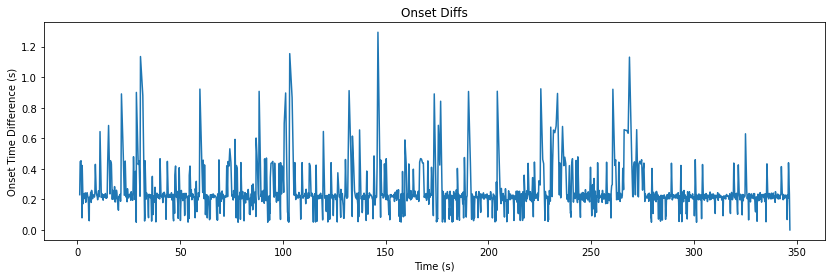

In [52]:
generateOnsetDiffs(res1)

soh
soh


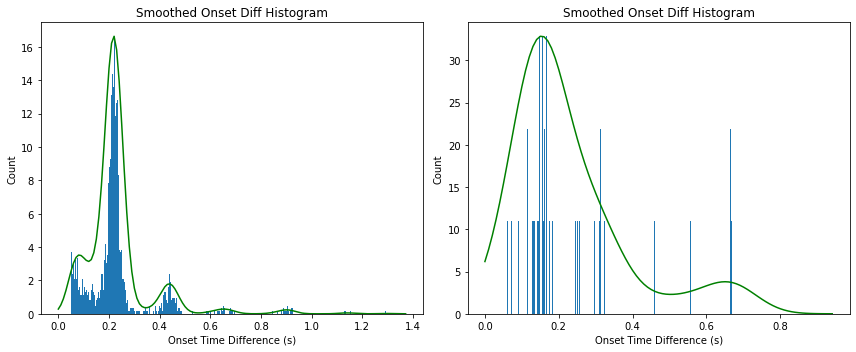

In [56]:
fig, axes = plt.subplots(1,2, tight_layout = True, figsize = (12,5))
axes.flatten()
generateSmoothedOnsetHistogram(res1, axes[0])
generateSmoothedOnsetHistogram(res2, axes[1])

The blue bars of the graph represent the onset difference while the green line represents the Parzen smoothed probability density function. So, the density of onset differences in the song.
We can see on the left-most plot, the onset time difference is mainly around 0.22 s. In other words, most onsets occurring in the song appear at an interval of 0.22s. Whereas, with "Watermelon Sugar" from Harry Styles, we've got more spread out onset time differences, which would underline a higher entropy. 

In [57]:
print(res1['entropy'])
print(res2['entropy'])

3.5417268383930107
3.9801131279267126


As expected, the entropy is greater for the Harry Styles song (number 2). 

---

In [21]:
# function that takes audio info and image as an imput an returns set of images for the frame
def get_gif(info, img_address):
    img = cv2.imread(img_address)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ln = len(info)
    amplitudes = []
    for i in range(ln):
        amplitudes.append(info[i]['amplitude'].max())
    br_values = np.array(amplitudes) / min(amplitudes)
    # this arguments just hand picked, so the images looks different
    # for final version better use proper transformation
    a = 19.14
    b = -64.12
    br_values = br_values * a + b
    br_values = np.array(br_values, dtype=int)
    new_imgs = []
    for v in br_values:
        new_imgs.append(change_brightness(img, v))
    return new_imgs

In [22]:
from os.path import abspath
from os.path import join as p_join
PROJDIR = abspath('')
new_imgs = get_gif(frames, p_join(PROJDIR,'data/apple.jpg'))

KeyError: 'amplitude'

In [ ]:
# basic visualization of images in result
fig = plt.figure(figsize=(20, 20))
for i in range(1,len(new_imgs)):
    fig.add_subplot(5,6,i)
    plt.imshow(new_imgs[i])
plt.show()

In [ ]:
# this function is for making gif, the problem I didn't find an argument on how to change the time for particular image
# so, it will need additional coding
import imageio
with imageio.get_writer(f'out.gif', mode='I') as writer:
    for new_img in new_imgs:
        writer.append_data(new_img)

Also, here we should collect the similarity metrics vector. 
Approximately, it should look like that:
```
def img_metric(imgs):
    vec = []
    for i in range(len(imgs) - 1):
        vec.append(rmse(imgs[i], imgs[i + 1]))
    return vec
    
def audio_metric(frames):
    ...
    return some_vec

audio_vec = normalize(audio_metric...)
img_vec = normalize(img_metric...)
Goal_metric = cosine_distance(audio_vec, img_vec)
```

The goal is to make the best goal metric, which will be equal to similarity between vectors.

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp
import IPython
from IPython.display import Audio
from scipy.io import wavfile
import math
import cv2
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams["figure.figsize"] = (14,4)
import librosa
# additional libraries for metrics
from sklearn.metrics import mean_squared_error as rmse
from skimage.measure import compare_mse as mse
from tqdm import tqdm
from scipy.spatial.distance import cosine
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

In [46]:
def get_info(audio_name, window_size):
    # audio_name -- name of audiofile
    # window_size -- we split audio into frames, this is the length of the frame in seconds
    x, sr = librosa.load(audio_name)
    seconds = len(x) / sr
    frame_len = int(len(x) / (seconds / window_size))
    frames = []
    for ind in range(0, len(x) + 1, frame_len):
        current_amplitude = x[ind:ind + frame_len]
        fft = librosa.stft(current_amplitude, n_fft=len(current_amplitude), hop_length=len(current_amplitude))
        freqs = fft[:, 0]
        freqs = librosa.amplitude_to_db(abs(freqs))
        _, phase = librosa.magphase(fft)
        phase = phase[:, 0]
        frames.append({'amplitude':current_amplitude, 'frequency':freqs, 'phase':phase})
        #timbre = 0
    return frames
audio_name = 'data/snd.wav'
frames = get_info(audio_name, 0.5)

In [47]:
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    new_img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return new_img

def decrease_brightness(img, value=-30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = -value
    v[v < lim] = 0
    v[v >= lim] -= (-value)

    final_hsv = cv2.merge((h, s, v))
    new_img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return new_img

def change_brightness(img, value=0):
    if value == 0:
        return img
    if value < 0:
        return decrease_brightness(img, value)
    return increase_brightness(img, value)

# function that takes audio info and image as an imput an returns set of images for the frame
def get_gif(info, img_address):
    img = cv2.imread(img_address)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ln = len(info)
    amplitudes = []
    for i in range(ln):
        amplitudes.append(info[i]['amplitude'].max())
    br_values = np.array(amplitudes) / min(amplitudes)
    # this arguments just hand picked, so the images looks different
    # for final version better use proper transformation
    a = 19.14
    b = -64.12
    br_values = br_values * a + b
    br_values = np.array(br_values, dtype=int)
    new_imgs = []
    for v in br_values:
        new_imgs.append(change_brightness(img, v))
    return new_imgs

new_imgs = get_gif(frames, 'data/apple.jpg')

In [49]:
def img_metric(imgs):
    vec = []
    for i in range(len(imgs) - 1):
        vec.append(np.sqrt(mse(imgs[i], imgs[i + 1])))
    return np.array(vec)

def audio_metric(frames):
    vec = []
    for i in tqdm(range(len(frames) - 1)):
        distance, _ = fastdtw(frames[i]['amplitude'], frames[i + 1]['amplitude'], dist=euclidean)
        vec.append(distance)
    return np.array(vec)

def cosine_distance(imgs, frames):
    img_vec = img_metric(new_imgs)
    audio_vec = audio_metric(frames)
    return cosine(img_vec, audio_vec)

print(cosine_distance(new_imgs, frames)) # the smaller the better since (1 - normed dot product)

C:\Users\Poly\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: DEPRECATED: skimage.measure.compare_mse has been moved to skimage.metrics.mean_squared_error. It will be removed from skimage.measure in version 0.18.
  after removing the cwd from sys.path.
100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:04<00:00,  6.92s/it]

0.17086154831075118
